# Identify fraud from Enron email


### Abstract


**1. Project goal**

The goal for this project is to classify person of interest from the dataset.
The original dataset has 146 rows and 21 features. On exploring I found 2 entries in the data that I remove.

One entries 'TOTAL' is most likely a spreadsheet quirk. And another one 'THE TRAVEL AGENCY IN THE PARK' is most likely inputted by mistake. I also remove another entry, 'LOCKHART EUGENE E', because it does not seems to have any other information (most field is NaN, and POI is False).

**2. Features**

In the end I am using 4 features, they are:
- exercised_stock_options
- total_stock_value
- bonus
- salary

The data has 21 features. I first reduce this to 14 by excluding features that has little information, 60% or more of the data are NaN. I then added 2 new features. The new features are based on the existing features.
There are 'from_poi_to_this_person' and 'from_this_person_to_poi' features.
The features are not that helpful. So I added two new features that scale these features by the total number.

I did not do scaling to any of the features (I did try to add it when running Linear SVM to see if it can improve the result). I think the data is highly skewed, there are only a handful of POI. And those people usually are outliers in term of bonus, salary, etc. This lead me to believe no scaling is needed.

I then run SelectKbest algorithm to reduce this to 4. I feel like this is a good number to start, and the plan was to start with 4 and then slowly add more features if needed.

The top 4 features scores are:

- exercised_stock_options: 24.815079733218194
- total_stock_value: 24.182898678566879
- bonus: 20.792252047181535
- salary 18.289684043404513

**3. Algorithm**

I used 3 algorithm:

- Gaussian Naive Bayes
- Linear SVC
- KNeighborsClassifier

I started out using Gaussian Naive Bayes, I then try to use Linear SVC before moving to KNeighbors
The result of the Linear SVC is the worst, both GNB and KNeighbors get the level of Precision and Recall that we set.

**4. Parameter tuning**

For my selected algorithm KNeighbors, I run the algorithm to give me a baseline and the result without parameter tunnings are:
    
Precision: 0.65971	Recall: 0.26850

I then run GridSearchCV to tune the parameter. The parameters before and after tuning is almost the same except the weight parameters. Even so, there is quite an improvement. Our result after tuning:

Precision: 0.69602	Recall: 0.36750

**5. Validation**

Validation is a process where we split data into 2 partitions, training and testing, and then use training for our  algorithm of choice and then use the testing partition to get the result. Without this process the algorithm might predict a good score but failed anything useful beyond the seen data or *overfitting*.

In this project I utilize scikit-learn StratifiedShuffleSplit.
Which will do rearrange the data as to ensure each fold is a good representative of the whole (stratification) and shuffle the data. 

**6. Evaluation**

The project uses 2 evaluation metrics, Precision and Recall. To be specific, we aim to have better then 0.3 for both Precision and Recall.

The result for the project are:
- Precision: 0.69602	
- Recall: 0.36750

That means when the algorithm mark someone as POI, the algorithm is correct for almost 70% of the time. 
We missed several POI, we got only around 36% correct POI out of all possible POI.

---

For this project the aim is to get both the recall and precision **better then 0.3**.

Before we do anything, let's run the most basic classifier used in the original poi_id.py. We will use this as baseline for further improvement.

In [1]:
# Notebook stuff
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn.naive_bayes import GaussianNB
from utils import setup_and_test, get_original_data

# Get data
data = get_original_data()
# Use Gaussian NB, this is our baseline classifier
clf = GaussianNB()
# Print out the result
setup_and_test(data, ['poi','salary'], clf)

GaussianNB()
	Accuracy: 0.25560	Precision: 0.18481	Recall: 0.79800	F1: 0.30011	F2: 0.47968
	Total predictions: 10000	True positives: 1596	False positives: 7040	False negatives:  404	True negatives:  960



Okay we can see that the accuracy is not that great. And the precision is very low.

## 1. Dataset and questions

I am going to explore the data to gain more understanding. I will utilize Pandas for this.

### 1.1 Basic information on the data

In [3]:
import pandas as pd
import numpy as np

In [4]:
# Create dataframe from the original data.
df = pd.DataFrame.from_dict(data).transpose()

Let's check the basic information on our data now. We are interested in columns and summary of the data.
Let's start with number of data and columns name.

In [5]:
# Data size
len(df)

146

In [6]:
# Column/features
df.columns

Index([u'bonus', u'deferral_payments', u'deferred_income', u'director_fees',
       u'email_address', u'exercised_stock_options', u'expenses',
       u'from_messages', u'from_poi_to_this_person',
       u'from_this_person_to_poi', u'loan_advances', u'long_term_incentive',
       u'other', u'poi', u'restricted_stock', u'restricted_stock_deferred',
       u'salary', u'shared_receipt_with_poi', u'to_messages',
       u'total_payments', u'total_stock_value'],
      dtype='object')

Okay so we got **146 rows** and **21 features**.

Let's take a look at the index.

In [7]:
# Check the Index
index_list = list(df.index)
index_list_len = len(index_list)
split = index_list_len/4

for col1, col2, col3, col4 in zip(index_list[0:split],
                                  index_list[split:split*2],
                                  index_list[split*2:split*3],
                                  index_list[split*3:]):
    print "{0:<25s} {1:<25s} {2:<25s} {3:<25s}".format(col1, col2, col3, col4)

ALLEN PHILLIP K           DODSON KEITH              KAMINSKI WINCENTY J       POWERS WILLIAM           
BADUM JAMES P             DONAHUE JR JEFFREY M      KEAN STEVEN J             PRENTICE JAMES           
BANNANTINE JAMES M        DUNCAN JOHN H             KISHKILL JOSEPH G         REDMOND BRIAN L          
BAXTER JOHN C             DURAN WILLIAM D           KITCHEN LOUISE            REYNOLDS LAWRENCE        
BAY FRANKLIN R            ECHOLS JOHN B             KOENIG MARK E             RICE KENNETH D           
BAZELIDES PHILIP J        ELLIOTT STEVEN            KOPPER MICHAEL J          RIEKER PAULA H           
BECK SALLY W              FALLON JAMES B            LAVORATO JOHN J           SAVAGE FRANK             
BELDEN TIMOTHY N          FASTOW ANDREW S           LAY KENNETH L             SCRIMSHAW MATTHEW        
BELFER ROBERT             FITZGERALD JAY L          LEFF DANIEL P             SHANKMAN JEFFREY A       
BERBERIAN DAVID           FOWLER PEGGY              LEMAISTRE CH

There are 2 weird index names here.
One 'TOTAL' and the other is 'THE TRAVEL AGENCY IN THE PARK'. 

Let's take a peek at those.

In [8]:
df.loc['THE TRAVEL AGENCY IN THE PARK']

bonus                           NaN
deferral_payments               NaN
deferred_income                 NaN
director_fees                   NaN
email_address                   NaN
exercised_stock_options         NaN
expenses                        NaN
from_messages                   NaN
from_poi_to_this_person         NaN
from_this_person_to_poi         NaN
loan_advances                   NaN
long_term_incentive             NaN
other                        362096
poi                           False
restricted_stock                NaN
restricted_stock_deferred       NaN
salary                          NaN
shared_receipt_with_poi         NaN
to_messages                     NaN
total_payments               362096
total_stock_value               NaN
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

In [9]:
df.loc['TOTAL']

bonus                         97343619
deferral_payments             32083396
deferred_income              -27992891
director_fees                  1398517
email_address                      NaN
exercised_stock_options      311764000
expenses                       5235198
from_messages                      NaN
from_poi_to_this_person            NaN
from_this_person_to_poi            NaN
loan_advances                 83925000
long_term_incentive           48521928
other                         42667589
poi                              False
restricted_stock             130322299
restricted_stock_deferred     -7576788
salary                        26704229
shared_receipt_with_poi            NaN
to_messages                        NaN
total_payments               309886585
total_stock_value            434509511
Name: TOTAL, dtype: object

It seems like 'THE TRAVEL AGENCY IN THE PARK' is inputted by mistake. And the total is basically summary of other entries, a spreadsheet quirk. Let's remove them.

In [10]:
# Remove TOTAL
df.drop(df.index[df.index == 'TOTAL'], inplace=True)
# Remove THE TRAVEL AGENCY IN THE PARK
df.drop(df.index[df.index == 'THE TRAVEL AGENCY IN THE PARK'], inplace=True)

In [11]:
# Verify
'TOTAL' not in list(df.index) and 'THE TRAVEL AGENCY IN THE PARK' not in list(df.index)

True

So now we have **144 rows** and **21 features**

In [12]:
# Check several entry of the data
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,NaN,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,NaN,178980,NaN,NaN,NaN,257817,3486,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,182466,257817
BANNANTINE JAMES M,NaN,NaN,-5104,NaN,james.bannantine@enron.com,4046157,56301,29,39,0,...,NaN,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,NaN,frank.bay@enron.com,NaN,129142,NaN,NaN,NaN,...,NaN,69,False,145796,-82782,239671,NaN,NaN,827696,63014


In [13]:
# Check the summary
df.describe()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,144,144,144,144,144,144,144,144,144,144,...,144,144,144,144,144,144,144,144,144,144
unique,41,39,44,17,112,101,94,65,58,42,...,52,91,2,97,18,94,84,87,124,124
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,63,106,96,128,33,43,50,58,58,58,...,79,53,126,35,127,50,58,58,21,19


The data description is not quite what I wanted. I expect to see the descriptive statistics information of the data. But this is not what I get in return. This is because Pandas treat each columns as string now. Let's fix that.

In [14]:
# This are columns that should be represented as number
float_columns = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 
 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person',
 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other',
 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
 'to_messages', 'total_payments', 'total_stock_value']

In [15]:
# do the conversion
df[float_columns] = df[float_columns].astype('float')

In [16]:
# Let's recheck that
df.describe()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
count,81.000000,38.000000,48.000000,16.000000,101.000000,94.000000,86.000000,86.000000,86.000000,3.000000,65.000000,91.000000,109.000000,17.000000,94.000000,86.000000,86.000000,1.230000e+02,125.000000
mean,1201773.074074,841602.526316,-581049.812500,89822.875000,2959559.257426,54192.010638,608.790698,64.895349,41.232558,27975000.000000,746491.200000,466410.516484,1147424.091743,621892.823529,284087.542553,1176.465116,2073.860465,2.641806e+06,3352073.024000
std,1441679.438330,1289322.626180,942076.402972,41112.700735,5499449.598994,46108.377454,1841.033949,86.979244,100.073111,46382560.030684,862917.421568,1397375.607531,2249770.356903,3845528.349509,177131.115377,1178.317641,2582.700981,9.524694e+06,6532883.097201
min,70000.000000,-102500.000000,-3504386.000000,3285.000000,3285.000000,148.000000,12.000000,0.000000,0.000000,400000.000000,69223.000000,2.000000,-2604490.000000,-1787380.000000,477.000000,2.000000,57.000000,1.480000e+02,-44093.000000
25%,425000.000000,79644.500000,-611209.250000,83674.500000,506765.000000,22479.000000,22.750000,10.000000,1.000000,1200000.000000,275000.000000,1203.000000,252055.000000,-329825.000000,211802.000000,249.750000,541.250000,3.969340e+05,494136.000000
50%,750000.000000,221063.500000,-151927.000000,106164.500000,1297049.000000,46547.500000,41.000000,35.000000,8.000000,2000000.000000,422158.000000,51587.000000,441096.000000,-140264.000000,258741.000000,740.500000,1211.000000,1.101393e+06,1095040.000000
75%,1200000.000000,867211.250000,-37926.000000,112815.000000,2542813.000000,78408.500000,145.500000,72.250000,24.750000,41762500.000000,831809.000000,331983.000000,985032.000000,-72419.000000,308606.500000,1888.250000,2634.750000,2.087530e+06,2606763.000000
max,8000000.000000,6426990.000000,-833.000000,137864.000000,34348384.000000,228763.000000,14368.000000,528.000000,609.000000,81525000.000000,5145434.000000,10359729.000000,14761694.000000,15456290.000000,1111258.000000,5521.000000,15149.000000,1.035598e+08,49110078.000000


That is better!

### 1.2 Missing data

There are a lot of 'NaN' in the data entries, let's take a look at how many in the data. And the percentage of the NaN data.

In [17]:
for idx, item in enumerate(df[float_columns].isnull().sum()):
    print "%30s %4s %7.5s%%" % (float_columns[idx], item, (item * 100.0) / len(df))

                         bonus   63   43.75%
             deferral_payments  106   73.61%
               deferred_income   96   66.66%
                 director_fees  128   88.88%
       exercised_stock_options   43   29.86%
                      expenses   50   34.72%
                 from_messages   58   40.27%
       from_poi_to_this_person   58   40.27%
       from_this_person_to_poi   58   40.27%
                 loan_advances  141   97.91%
           long_term_incentive   79   54.86%
                         other   53   36.80%
              restricted_stock   35   24.30%
     restricted_stock_deferred  127   88.19%
                        salary   50   34.72%
       shared_receipt_with_poi   58   40.27%
                   to_messages   58   40.27%
                total_payments   21   14.58%
             total_stock_value   19   13.19%


Several of the features has a lot of NaN. Let's take a look at one of them.

In [18]:
# Show the director_fees and poi with no NaN
df[['director_fees', 'poi']].dropna()

,director_fees,poi
BELFER ROBERT,3285,False
BHATNAGAR SANJAY,137864,False
BLAKE JR. NORMAN P,113784,False
CHAN RONNIE,98784,False
DUNCAN JOHN H,102492,False
GRAMM WENDY L,119292,False
JAEDICKE ROBERT,108750,False
LEMAISTRE CHARLES,112492,False
MENDELSOHN JOHN,103750,False
MEYER JEROME J,38346,False


In [19]:
# Show director fees where the POI is true
temp = df[['director_fees', 'poi']]
temp[temp.poi==True]

,director_fees,poi
BELDEN TIMOTHY N,NaN,True
BOWEN JR RAYMOND M,NaN,True
CALGER CHRISTOPHER F,NaN,True
CAUSEY RICHARD A,NaN,True
COLWELL WESLEY,NaN,True
DELAINEY DAVID W,NaN,True
FASTOW ANDREW S,NaN,True
GLISAN JR BEN F,NaN,True
HANNON KEVIN P,NaN,True
HIRKO JOSEPH,NaN,True


So if someone does not take director's fee can we say that they are POI?
If we include this in our features list, this might introduces biases and mistakes. So to avoid that I am **not** going to include features that has 60% or more NaN to begin with. Of course including it might actually be useful. But for now I will start with those features that does not have too much NaN value.

We have looked at the distribution by column. But we can also consider this. If a row in the data is fill with mostly NA, we might need to exclude the data.

In [20]:
transposed = df.transpose()
for idx, item in enumerate(transposed.isnull().sum()):
    # Since there is 144 entry, let's just print the row, if it
    # has 17 column mark as NaN (around 80%).
    if item >= 17:
        print "%30s %4s %7.5s%%" % (transposed.columns[idx], item, (item * 100.0) / len(transposed))

                 GRAMM WENDY L   17   80.95%
             LOCKHART EUGENE E   19   90.47%
             SCRIMSHAW MATTHEW   17   80.95%
                WHALEY DAVID A   17   80.95%
                 WODRASKA JOHN   17   80.95%
                  WROBEL BRUCE   17   80.95%


After looking at each of the row above. Other then 'LOCKHART EUGENE E' every other entry seems to have at least one valid information. So I am going to remove 'LOCKHART EUGENE E'.

In [21]:
# Let's take a look at the entry
df.loc['LOCKHART EUGENE E']

bonus                          NaN
deferral_payments              NaN
deferred_income                NaN
director_fees                  NaN
email_address                  NaN
exercised_stock_options        NaN
expenses                       NaN
from_messages                  NaN
from_poi_to_this_person        NaN
from_this_person_to_poi        NaN
loan_advances                  NaN
long_term_incentive            NaN
other                          NaN
poi                          False
restricted_stock               NaN
restricted_stock_deferred      NaN
salary                         NaN
shared_receipt_with_poi        NaN
to_messages                    NaN
total_payments                 NaN
total_stock_value              NaN
Name: LOCKHART EUGENE E, dtype: object

In [22]:
# Drop the entry
df.drop(df.index[df.index == 'LOCKHART EUGENE E'], inplace=True)

In [23]:
# Verify if the entry is gone
'LOCKHART EUGENE E' not in list(df.index)

True

In [24]:
# Recheck our data entry
len(df)

143

Okay so in the end we have **143 row**.

### 1.3 POI allocation

Let's also take a look at how many rows that has 'poi' marked as True.

In [25]:
len(df[df.poi == True])

18

That means only about 12% (18/145) of the entire data that is marked as POI. This make sense, big corporation like Enron typically only have a handful of people making the calls.

### 1.4 Data distribution

Let's do a simple distribution plot for the each of the feature.

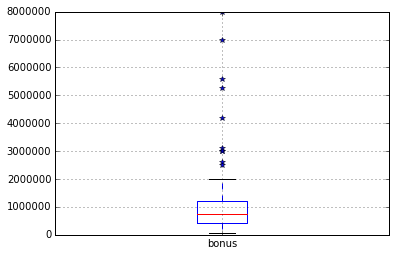

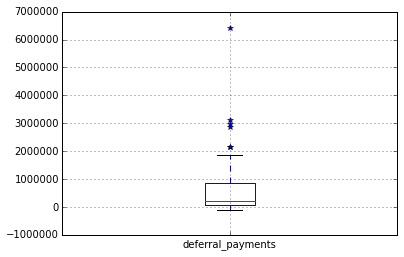

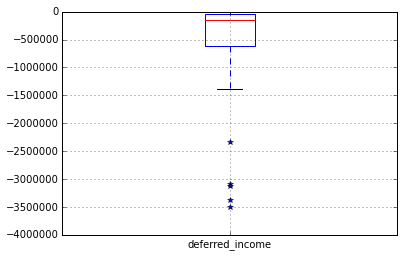

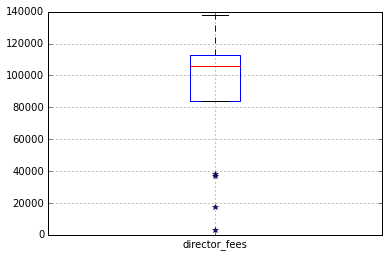

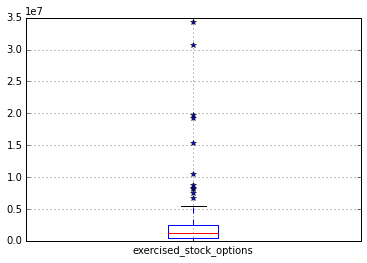

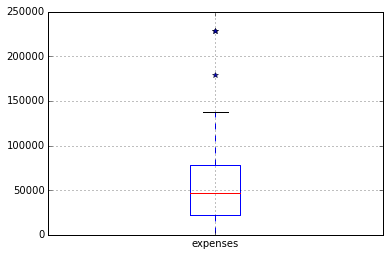

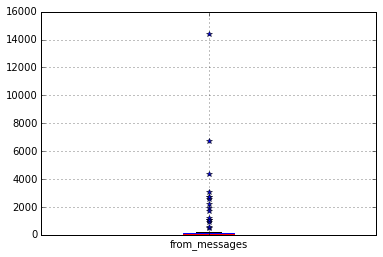

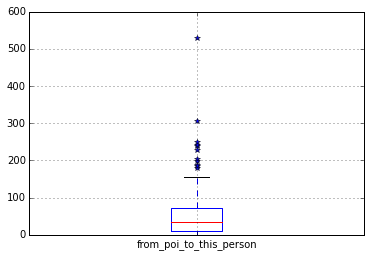

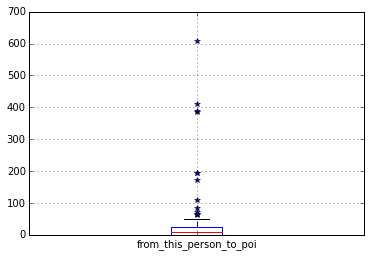

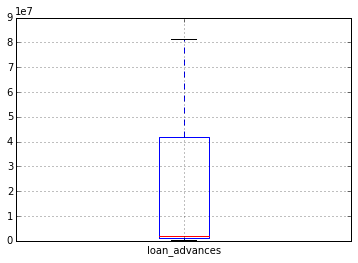

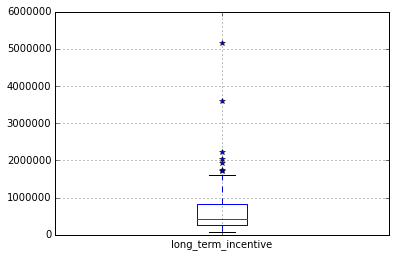

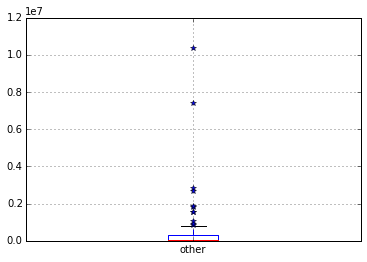

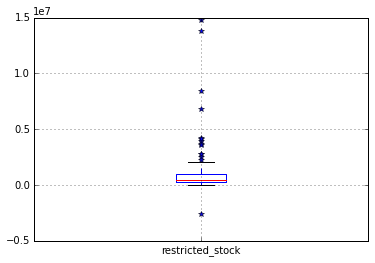

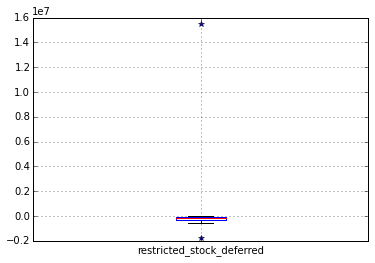

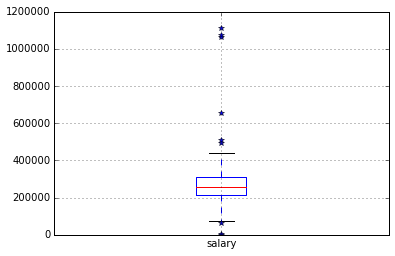

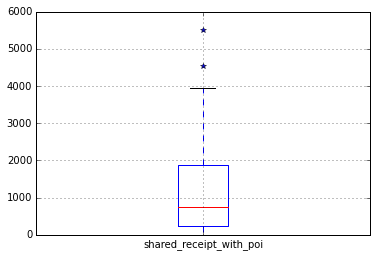

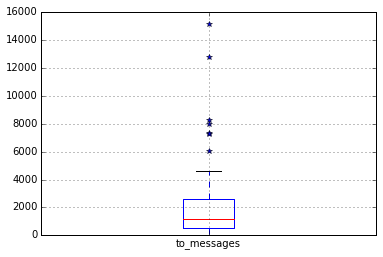

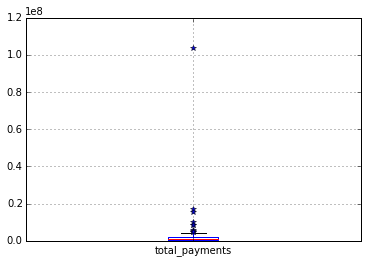

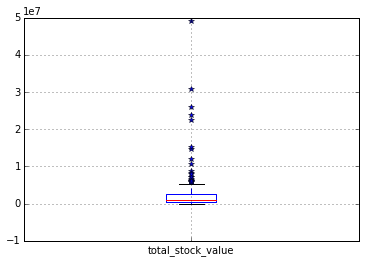

In [26]:
# List of columns with no features that has more then 60% NaN
data_columns = ['bonus', 'exercised_stock_options', 'expenses',
                'from_messages', 'from_poi_to_this_person',
                'from_this_person_to_poi',  'long_term_incentive', 'other',
                'restricted_stock', 'salary', 'shared_receipt_with_poi',
                'to_messages', 'total_payments', 'total_stock_value']

for item in float_columns:
    df[[item]].plot(kind='box', sym='*')

For each features there seems to be a lot of outliers. However I am going to leave them. Because I think the outlier can actually act as indicator to help classify the person of interest. For instance in the bonus section, the median is below 1 million, but someone got around 8 million in bonus.

---

## 2. Features selection

In the previous section I have reduce the features to 14 from the original 21 features (excluding features with 60% of data is NaN). If we look at the data there are 'from_poi_to_this_person' and 'from_this_person_to_poi' features.
The features are not that helpful. Let's add two new features that scale these features by the total number.
And let's visualize this.

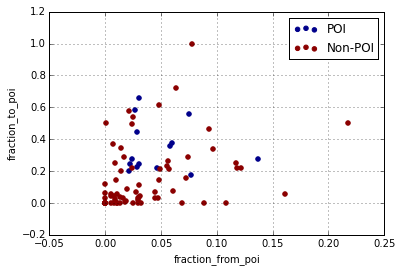

In [27]:
# Fraction from POI
df['fraction_from_poi'] = df.apply(lambda x:x['from_poi_to_this_person'] / x['to_messages'], axis=1)

# Fraction to POI
df['fraction_to_poi'] = df.apply(lambda x:x['from_this_person_to_poi'] / x['from_messages'], axis=1)

# Visualize the new features
groups = df.groupby(['poi'])
plot1 = groups.get_group(True).plot(kind='scatter', x='fraction_from_poi', y='fraction_to_poi',
                                    color='DarkBlue', label='POI');

groups.get_group(False).plot(kind='scatter', x='fraction_from_poi', y='fraction_to_poi',
                            color='DarkRed', label='Non-POI', ax=plot1);

The visualization looks pretty good.

While the red points aren't particularly tightly clustered.
There do seem to be big chunks of feature space where there is no persons of interest at all (fraction_to_poi less than 0.2).

So I have minimize the number of features down to 14 from original 21 features and add 2 more new features. Making it a total of 16 features. 

Let's try to reduce the feature count. We will use SelectKBest feature selection method.
I will limit the number of features to be 4 for now and add it later if it is necessary.

In [28]:
from sklearn.feature_selection import SelectKBest
from tools.feature_format import featureFormat, targetFeatureSplit


def get_k_best_features(data, features_list, k):
    # Setup the label and features
    data = featureFormat(data, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    
    # Apply SelectKBest
    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    
    # pair up with feature name, ignore the first one, since 
    # that is the 'poi' label
    unsorted_pairs = zip(features_list[1:], scores)
    
    # Sort based on score
    sorted_pairs = list(sorted(unsorted_pairs, key=lambda x: x[1], reverse=True))

    return sorted_pairs

In [29]:
# Transform the data back to dictionary, the helper library
# assume the input is in dictionary.
data = df.fillna('NaN').transpose().to_dict()

data_columns += ['fraction_from_poi', 'fraction_to_poi']

# get K-best features, include 'poi' features, helper library need this
kbest_features = get_k_best_features(data, ['poi'] + data_columns, 4)

# Print the score
print "KBest Features scores:"
kbest_features

KBest Features scores:


[('exercised_stock_options', 24.815079733218194),
 ('total_stock_value', 24.182898678566879),
 ('bonus', 20.792252047181535),
 ('salary', 18.289684043404513),
 ('fraction_to_poi', 16.409712548035792),
 ('long_term_incentive', 9.9221860131898225),
 ('restricted_stock', 9.2128106219771002),
 ('total_payments', 8.7727777300916756),
 ('shared_receipt_with_poi', 8.589420731682381),
 ('expenses', 6.0941733106389453),
 ('from_poi_to_this_person', 5.2434497133749582),
 ('other', 4.1874775069953749),
 ('fraction_from_poi', 3.1280917481567192),
 ('from_this_person_to_poi', 2.3826121082276739),
 ('to_messages', 1.6463411294420076),
 ('from_messages', 0.16970094762175533)]

In [30]:
# Get the top 4 features
kbest_features = [item[0] for item in kbest_features[:4]]

# Let's see the features
kbest_features

['exercised_stock_options', 'total_stock_value', 'bonus', 'salary']

All of our features are financial features. For now we will only use these 4 features. We will add some more features to see if we can improve the result later on but for now let's just use these 4 features.

## 3. Algorithms

First, let's convert the data we processed with Pandas back into dictionary

In [31]:
new_data = df.fillna('NaN').transpose().to_dict()
new_feature_list = ['poi'] + kbest_features

### 3.1 Gaussian Naive Bayes

Let's rerun the Gaussian Naive Bayes with the new features.

In [32]:
clf = GaussianNB()
setup_and_test(new_data, new_feature_list, clf)

GaussianNB()
	Accuracy: 0.84677	Precision: 0.50312	Recall: 0.32300	F1: 0.39342	F2: 0.34791
	Total predictions: 13000	True positives:  646	False positives:  638	False negatives: 1354	True negatives: 10362



Things have improved a lot. But the precision is already better then 0.3.
Let's see if other algorithm can beat this.

### 3.2 Linear SVM

In [33]:
from sklearn import svm

clf = svm.LinearSVC()
setup_and_test(new_data, new_feature_list, clf)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
	Accuracy: 0.68031	Precision: 0.17393	Recall: 0.28750	F1: 0.21674	F2: 0.25429
	Total predictions: 13000	True positives:  575	False positives: 2731	False negatives: 1425	True negatives: 8269



That does not look too good. Let's try to apply scaler on the feature before we run the algorithm.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
pipeline = Pipeline([('normalization', scaler),
                     ('classifier', clf)
])

setup_and_test(new_data, new_feature_list, pipeline)


Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.84746	Precision: 0.51919	Recall: 0.11500	F1: 0.18829	F2: 0.13621
	Total predictions: 13000	True positives:  230	False positives:  213	False negatives: 1770	True negatives: 10787



Much better, but the recall is pretty low, which mean our algorithm tend to mark people as non-POI.

We haven't tune the parameter for the Linear SVC above so let's try to do it now.

In [35]:
clf = svm.LinearSVC(dual=False, loss='squared_hinge', penalty='l1')
pipeline = Pipeline([('normalization', scaler),
                     ('classifier', clf)
])

setup_and_test(new_data, new_feature_list, pipeline)

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0))])
	Accuracy: 0.84815	Precision: 0.53186	Recall: 0.10850	F1: 0.18023	F2: 0.12904
	Total predictions: 13000	True positives:  217	False positives:  191	False negatives: 1783	True negatives: 10809



Let's try to use GridSearch to tune the parameters.

In [36]:
from sklearn.grid_search import GridSearchCV

data2 = featureFormat(new_data, new_feature_list)
labels, features = targetFeatureSplit(data2)

# Scale the features
features = MinMaxScaler().fit_transform(features)

loss = ['hinge', 'squared_hinge', ]
penalty = ['l2']
multi_class = ['ovr', 'crammer_singer']
param_grid = dict(loss=loss, penalty=penalty)
clf_lsvc = GridSearchCV(svm.LinearSVC(), param_grid=param_grid)
clf_lsvc.fit(features, labels)
print "Tuned Linear SVC estimator is: \n", clf_lsvc.best_estimator_
print clf_lsvc.best_score_
print ""
clf_lsvc = clf_lsvc.best_estimator_

pipeline = Pipeline([('normalization', scaler),
                     ('classifier', clf_lsvc)
])

setup_and_test(new_data, new_feature_list, pipeline)

Tuned Linear SVC estimator is: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
0.861538461538

Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
	Accuracy: 0.84631	Precision: 0.75000	Recall: 0.00150	F1: 0.00299	F2: 0.00187
	Total predictions: 13000	True positives:    3	False positives:    1	False negatives: 1997	True negatives: 10999



That is actually terrible, while the precision is up significantly the recall is bad. Also we only predicted 3 True Positives.

Let's add some cross validation to our GridSearchCV, instead of using the default one.

In [37]:
from sklearn.cross_validation import StratifiedShuffleSplit

data2 = featureFormat(new_data, new_feature_list)
labels, features = targetFeatureSplit(data2)

# Scale the features
features = MinMaxScaler().fit_transform(features)

cv = StratifiedShuffleSplit(labels, 1000, random_state=17)

loss = ['hinge', 'squared_hinge', ]
penalty = ['l2']
multi_class = ['ovr', 'crammer_singer']
param_grid = dict(loss=loss, penalty=penalty)
clf_lsvc = GridSearchCV(svm.LinearSVC(), param_grid=param_grid, cv=cv)
clf_lsvc.fit(features, labels)

print "Tuned Linear SVC estimator is: \n", clf_lsvc.best_estimator_
print clf_lsvc.best_score_

clf_lsvc = clf_lsvc.best_estimator_
pipeline = Pipeline([('normalization', scaler),
                     ('classifier', clf_lsvc)
])

setup_and_test(new_data, new_feature_list, pipeline)

Tuned Linear SVC estimator is: 
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
0.846153846154
Pipeline(steps=[('normalization', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
	Accuracy: 0.84631	Precision: 0.75000	Recall: 0.00150	F1: 0.00299	F2: 0.00187
	Total predictions: 13000	True positives:    3	False positives:    1	False negatives: 1997	True negatives: 10999



Okay this is not getting any good. So we will leave this for now.

### 3.3 Select KNeighbors

In [38]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
setup_and_test(new_data, new_feature_list, clf)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
	Accuracy: 0.86615	Precision: 0.65971	Recall: 0.26850	F1: 0.38166	F2: 0.30463
	Total predictions: 13000	True positives:  537	False positives:  277	False negatives: 1463	True negatives: 10723



This is not bad, by using the default parameters we already get much better precision and recall then Linear SVM.
Let's again turn to GridSearchCV to get the best parameter

In [39]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

# Setup label and features
data2 = featureFormat(new_data, new_feature_list)
labels, features = targetFeatureSplit(data2)

# Parameters to be tuned
metrics = ['minkowski', 'euclidean', 'manhattan']
weights = ['uniform', 'distance']
n_neighbors = [1,2,3,4,5,6,7,8,9,10]
param_grid_knc = dict(metric=metrics, weights=weights, n_neighbors=n_neighbors)

# Setup cross validation
cv = StratifiedShuffleSplit(labels, 1000, random_state=17)

# Run the GridSearch
clf_knc = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_knc, cv=cv)
clf_knc.fit(features, labels)

# Print out info
print "Tuned KNeighborsClassier estimator is: \n", clf_knc.best_estimator_

Tuned KNeighborsClassier estimator is: 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')


In [40]:
setup_and_test(new_data, new_feature_list, clf_knc.best_estimator_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')
	Accuracy: 0.87800	Precision: 0.69602	Recall: 0.36750	F1: 0.48102	F2: 0.40581
	Total predictions: 13000	True positives:  735	False positives:  321	False negatives: 1265	True negatives: 10679



# 4. Conclusion

After runing KNeighborsClassifier, we have hit our goal of getting at least **0.3** for both Precision and Recall.